In [5]:
import os
import dask
from tqdm.dask import TqdmCallback
import pandas as pd
import geopandas as gpd
from pathlib import Path
from tqdm import tqdm
import seaborn as sns
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import geopy.distance
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
import sys
sys.path.append(r'C:\Users\tacuevas\Documents\GitHub\concorde\modules')
from plots import scatter_interpolate
from shapely.geometry import Point, Polygon, LineString
import warnings
warnings.filterwarnings("ignore")
import itertools
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 14})
from matplotlib.offsetbox import AnchoredText

In [11]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

###### Format Data

In [11]:
pathin = Path(r'T:\Projects\2016-2020-DHS-CRCoE\Tomas\Thesis\data\STORM\raw\STORM_data')
filesIn = [x for x in os.listdir(pathin) if '_NA_' in x]

In [12]:
columns = ['year', 'month', 'yr_tc_number', 'time_step', 'basin_id', 'lat', 'lon', 'min_press',
          'max_ws', 'rad_to_max_ws', 'cat', 'landfall', 'dist_to_land']

In [31]:
dfs = []
for ifile, file in tqdm(enumerate(filesIn)):
    df = pd.read_csv(pathin/file, header = None, names = columns)
    df['year'] = df['year'] + ifile * 1000
    dfs.append(df)
    
dfs = pd.concat(dfs, axis = 0)
dfs.index = range(len(dfs))

10it [00:07,  1.30it/s]


In [32]:
dfs['lon'] = np.mod(dfs['lon'].values - 180, 360.) - 180

In [33]:
dfs.head()

,year,month,yr_tc_number,time_step,basin_id,lat,lon,min_press,max_ws,rad_to_max_ws,cat,landfall,dist_to_land
0,0.0,10.0,0.0,0.0,1.0,8.9,-45.2,993.946699,20.371998,46.299999,0.0,0.0,851.946656
1,0.0,10.0,0.0,1.0,1.0,9.0,-45.7,992.800000,21.200000,45.905957,0.0,0.0,815.967429
2,0.0,10.0,0.0,2.0,1.0,9.1,-46.4,992.100000,21.700000,45.511914,0.0,0.0,766.103506
3,0.0,10.0,0.0,3.0,1.0,9.2,-47.3,993.000000,21.100000,45.117872,0.0,0.0,705.759651
4,0.0,10.0,0.0,4.0,1.0,9.3,-48.3,993.100000,20.900000,44.723829,0.0,0.0,647.548285


In [29]:
index_start = np.where(dfs.time_step == 0)[0]
list0 = []
count = 0
for i, j in zip(index_start[:-1], index_start[1:]):
    list0.extend([count] * (j - i))
    count += 1
list0.extend([count] * (len(dfs) - j))
dfs['tc_number'] = list0

In [32]:
dfs.to_pickle(r'C:\Users\tacuevas\NCSU\Research\Thesis\data\STORM\processed\STORM_NA.pkl')

In [6]:
geom = []
cat = []
for i in dfs.tc_number.unique():
    subdf = dfs[dfs.tc_number == i]
    ls = LineString(list(zip(subdf.lon, subdf.lat)))
    geom.append(ls)
    cat.append(subdf.cat.max())
gdf = gpd.GeoDataFrame(geometry = geom, crs = 4326)
gdf['cat_max'] = cat

In [7]:
gdf.to_file(r'C:\Users\tacuevas\NCSU\Research\Thesis\data\STORM\processed\STORM_NA.shp')

C:\Users\tacuevas\AppData\Roaming\Python\Python39\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Add distance to NC

In [4]:
df = pd.read_pickle(r'C:\Users\tacuevas\NCSU\Research\Thesis\data\STORM\processed\STORM_NA.pkl')

In [6]:
nc = (35.2, -76.8)

In [7]:
@dask.delayed
def dist2NC(y, x, pnt):
    return geopy.distance.geodesic(pnt, (y, x)).km

tasks = [dist2NC(lat, lon, nc) for lat, lon in zip(df.lat, df.lon)]

In [8]:
with TqdmCallback(desc = "Computing distance"):
    d = dask.compute(tasks, scheduler = 'threads')

Computing distance:   0%|          | 0/3507558 [00:00<?, ?it/s]

In [9]:
df['dist_to_NC'] = d[0]

In [10]:
df.head()

,year,month,yr_tc_number,time_step,basin_id,lat,lon,min_press,max_ws,rad_to_max_ws,cat,landfall,dist_to_land,tc_number,dist_to_NC
0,0.0,10.0,0.0,0.0,1.0,8.9,-45.2,993.946699,20.371998,46.299999,0.0,0.0,851.946656,0,4336.133140
1,0.0,10.0,0.0,1.0,1.0,9.0,-45.7,992.800000,21.200000,45.905957,0.0,0.0,815.967429,0,4290.629311
2,0.0,10.0,0.0,2.0,1.0,9.1,-46.4,992.100000,21.700000,45.511914,0.0,0.0,766.103506,0,4230.498007
3,0.0,10.0,0.0,3.0,1.0,9.2,-47.3,993.000000,21.100000,45.117872,0.0,0.0,705.759651,0,4156.153101
4,0.0,10.0,0.0,4.0,1.0,9.3,-48.3,993.100000,20.900000,44.723829,0.0,0.0,647.548285,0,4075.371766


In [11]:
df.to_pickle(r'C:\Users\tacuevas\NCSU\Research\Thesis\data\STORM\processed\STORM_NA_R1.pkl')

In [3]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [36]:
df[df.time_step == 0]

,year,month,yr_tc_number,time_step,basin_id,lat,lon,min_press,max_ws,rad_to_max_ws,cat,landfall,dist_to_land,tc_number,dist_to_NC
0,0.0,10.0,0.0,0.0,1.0,8.9,-45.2,993.946699,20.371998,46.299999,0.0,0.0,851.946656,0,4336.133140
65,0.0,8.0,1.0,0.0,1.0,25.4,-88.9,997.749144,18.108442,22.223999,0.0,0.0,395.244365,1,1589.688389
76,0.0,8.0,2.0,0.0,1.0,15.4,-62.3,996.916798,18.108442,111.120003,0.0,0.0,90.403291,2,2627.935388
105,0.0,10.0,3.0,0.0,1.0,8.8,-50.0,993.678461,20.371998,46.299999,0.0,0.0,496.565472,3,3997.789171
125,0.0,11.0,4.0,0.0,1.0,22.1,-67.9,996.722057,20.371998,74.080002,0.0,0.0,337.632304,4,1690.713296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3507334,9999.0,8.0,12.0,0.0,1.0,13.6,-26.5,995.521732,18.108442,64.820000,0.0,0.0,236.671795,109474,5562.793169
3507340,9999.0,9.0,13.0,0.0,1.0,10.6,-46.3,992.939854,20.371998,18.520000,0.0,0.0,896.391372,109475,4116.531108
3507412,9999.0,8.0,14.0,0.0,1.0,23.5,-46.3,998.871609,20.371998,37.040001,0.0,0.0,1816.784731,109476,3216.162028
3507454,9999.0,11.0,15.0,0.0,1.0,26.7,-64.2,1001.780914,18.108442,31.483999,0.0,0.0,620.158065,109477,1526.625040


In [ ]:
### plot of origin point

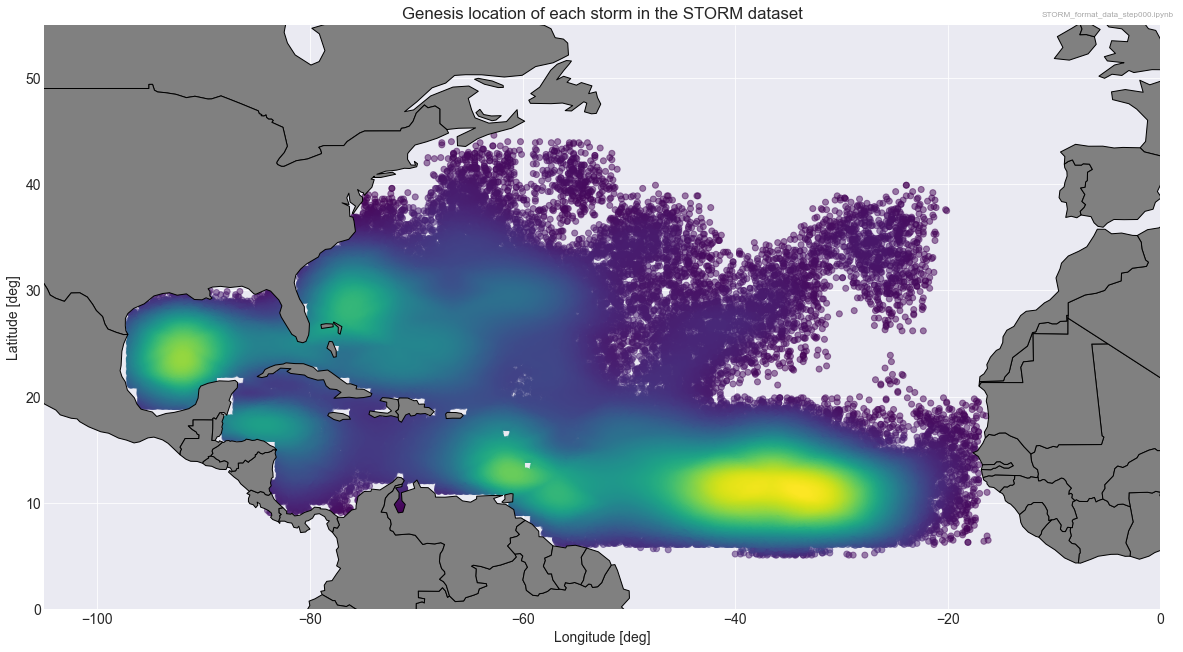

In [13]:
df = pd.read_pickle(r'C:\Users\tacuevas\NCSU\Research\Thesis\data\STORM\processed\STORM_NA_R2.pkl')
dfgen = df[df.time_step == 0]
x = dfgen.loc[:, 'lon'].values
y = dfgen.loc[:, 'lat'].values
z = scatter_interpolate(x,y)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
cm = plt.cm.get_cmap('viridis')

fig, ax = plt.subplots(figsize = (20, 20))
ax.scatter(x, y, c = z, cmap = cm, alpha = 0.5)
world.plot(ax = ax, color = 'grey', edgecolor = 'k')
ax.set_xlim([-105, 0])
ax.set_ylim([0, 55])
ax.set_aspect('equal')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.set_title('Genesis location of each storm in the STORM dataset')

text = AnchoredText(nb_name, 'upper right',frameon = False, borderpad = -2, prop=dict(fontsize = 'xx-small', alpha = 0.4))
ax.add_artist(text)

Study trajectory

In [4]:
df = pd.read_pickle(r'C:\Users\tacuevas\NCSU\Research\Thesis\data\STORM\processed\STORM_NA_R1.pkl')

In [3]:
df.head()

,year,month,yr_tc_number,time_step,basin_id,lat,lon,min_press,max_ws,rad_to_max_ws,cat,landfall,dist_to_land,tc_number,dist_to_NC
0,0.0,10.0,0.0,0.0,1.0,8.9,-45.2,993.946699,20.371998,46.299999,0.0,0.0,851.946656,0,4336.133140
1,0.0,10.0,0.0,1.0,1.0,9.0,-45.7,992.800000,21.200000,45.905957,0.0,0.0,815.967429,0,4290.629311
2,0.0,10.0,0.0,2.0,1.0,9.1,-46.4,992.100000,21.700000,45.511914,0.0,0.0,766.103506,0,4230.498007
3,0.0,10.0,0.0,3.0,1.0,9.2,-47.3,993.000000,21.100000,45.117872,0.0,0.0,705.759651,0,4156.153101
4,0.0,10.0,0.0,4.0,1.0,9.3,-48.3,993.100000,20.900000,44.723829,0.0,0.0,647.548285,0,4075.371766


In [24]:
xi = -100
yi = 50
xf = -60
yf = 5

box2 = gpd.GeoDataFrame(geometry = [Polygon([[xi, yi], [xi, yf], [xf, yf], [xf, yi], [xi, yi]])], crs = 4326)

In [5]:
def stormMeanDir(df):
    '''
    '''
    x = (df.loc[:, 'lon'].shift(-1) - df.loc[:, 'lon']).values
    y = (df.loc[:, 'lat'].shift(-1) - df.loc[:, 'lat']).values
    d = np.arctan2(x, y)
    d2 = np.rad2deg(d)
    d2 = np.mod(d2, 360)
    dmean = np.rad2deg(np.nanmean(d))
    dmean = np.mod(dmean, 360)
    return dmean, d2

In [6]:
@dask.delayed
def get_trajectory(df, i):
    dfsub = df[df.tc_number == i]
    d = stormMeanDir(dfsub)[1]    
    return d

tasks = [get_trajectory(df, i) for i in df.tc_number.unique()]
# tasks = [get_trajectory(df, i) for i in [88467]]#df.tc_number.unique()]

with TqdmCallback(desc = "Computing distance"):
    aux = dask.compute(tasks, scheduler = 'threads')
    
auxM = list(itertools.chain(*aux))
auxM = list(itertools.chain(*auxM))

df['trajectory'] = auxM

Computing distance:   0%|          | 0/109479 [00:00<?, ?it/s]

In [7]:
@dask.delayed
def get_mean_trajectory(df, i):
    dfsub = df[df.tc_number == i]
    d = stormMeanDir(dfsub)[0]    
    return [d]*len(dfsub)

tasks = [get_mean_trajectory(df, i) for i in df.tc_number.unique()]
# tasks = [get_mean_trajectory(df, i) for i in [88467]]#df.tc_number.unique()]

with TqdmCallback(desc = "Computing distance"):
    aux = dask.compute(tasks, scheduler = 'threads')
    
auxM = list(itertools.chain(*aux))
auxM = list(itertools.chain(*auxM))

df['mean_trajectory'] = auxM

Computing distance:   0%|          | 0/109479 [00:00<?, ?it/s]

In [9]:
df.to_pickle(r'C:\Users\tacuevas\NCSU\Research\Thesis\data\STORM\processed\STORM_NA_R2.pkl')

In [6]:
df = pd.read_pickle(r'C:\Users\tacuevas\NCSU\Research\Thesis\data\STORM\processed\STORM_NA_R2.pkl')

In [8]:
df.tc_number.nunique()

109479